1_data_quality_check.ipynb : Get to know the data to better produce injection
- Band pass analysis: Include a tool to sort the visit by band pass. Plot the position of the injection on all CCD. Calculate the magnitude based on the flux. Plot the magnitude and approximate it by a gaussian per CCD, for different apFlux. Plot the aperture magnitude regarding the psf magnitude. 

- Analysis on the sensor: check the CCD illumination, and the distribution of the flux on the CCD


# Import 

In [1]:
import os
import importlib
import pprint

import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

import numpy as np
import pandas as pd


import astropy.units as u
from astropy.coordinates import SkyCoord


import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler

from lsst.analysis.ap import apdb


#from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.daf.butler import Butler

from astropy.table import Table

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

import pickle
import scipy.stats as stats



In [2]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



# Data access configuration

In [3]:
repo = "/sps/lsst/groups/transients/HSC/fouchez/RC2_repo/butler.yaml"

In [5]:
# Create a new butler with the collection of interest
collection = 'run/ssp_ud_cosmos/step5'
butler = Butler(repo, collections = collection)
registry = butler.registry

#filter the dataset
datasetRefs = registry.queryDatasets(datasetType='goodSeeingDiff_assocDiaSrcTable', collections=collection)


In [6]:
dataIds = []
for i,ref in enumerate(datasetRefs):
    dataIds.append(ref.dataId)
print(len(dataIds))
print(dataIds[0])


46
{skymap: 'hsc_rings_v1', tract: 9813, patch: 4}


# Band pass analaysis

In [8]:
def extract_all_filter(band):
    dataIds = []
    result = registry.queryDatasets(datasetType='goodSeeingDiff_assocDiaSrcTable', 
                                    collections=collection,
                                   dataId=band)

    for ref in result:
        dataIds.append(ref.dataId)
        
    return dataIds

In [7]:
bands_label = [{'band': 'g'}, {'band': 'i'}, {'band': 'r'}, {'band': 'y'}, {'band': 'z'}, {'band': 'N921'}]

# Define the desired order of bands
desired_order = ['g', 'r', 'i', 'z', 'y', 'N921']

# Sort bands_list according to the desired_order
bands_label = sorted(bands_label, key=lambda x: desired_order.index(x['band']))

In [9]:
y = {'band': 'y'}

print(extract_all_filter(bands_label[0]))


[{skymap: 'hsc_rings_v1', tract: 9813, patch: 4}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 79}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 10}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 68}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 77}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 70}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 46}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 28}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 18}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 27}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 37}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 55}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 73}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 12}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 8}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 7}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 80}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 64}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 56}, {skymap: 'hsc_rings_v1', tract: 9813, patch: 67}, {s

## Position

In [132]:
full_dia_source_table =[]
for ref in datasetRefs: 
    dia_source_table =  butler.get('goodSeeingDiff_assocDiaSrcTable', dataId = ref.dataId)
    full_dia_source_table.append(dia_source_table)
    
full_dia_source_table = pd.concat(full_dia_source_table)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot the distribution of RA and Dec positions as heat maps for each bandpass
fig, axs = plt.subplots(1, len(bands_label), figsize=(20, 5), sharex=True, sharey=True)

for i, band in enumerate(desired_order) :
    ra = []
    dec = []
    for idx, row in full_dia_source_table.iterrows(): 
        if (band==row['band']): 
            ra.append(row['coord_ra'])
            dec.append(row['coord_dec'])
            
    # Create 2D histogram
    heatmap, xedges, yedges = np.histogram2d(ra, dec, bins=100)
    
    # Plot the heatmap with Greys colormap
    im = axs[i].imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                       origin='lower', aspect='auto', cmap='YlOrRd', vmin=0)
    axs[i].set_title(f'Band: {band}')
    axs[i].set_xlabel('RA')
    if i == 0:
        axs[i].set_ylabel('Dec')
    print(f'{band} : {len(ra)}')
    
# Adjust layout to accommodate colorbar
plt.tight_layout()

# Add a horizontal colorbar below the subplots
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Density')

plt.show()           


g : 92529
r : 86899
i : 233342
z : 392239
y : 275760
N921 : 82755


## Flux and Magnitude 

In [11]:
detecs = butler.get('goodSeeingDiff_assocDiaSrcTable', dataId=dataIds[0])

for col in detecs.columns:
    if 'flux ' in col or 'Flux' in col:
        print(col)

apFlux
apFluxErr
psfFlux
psfFluxErr
trailFlux
dipoleMeanFlux
dipoleMeanFluxErr
dipoleFluxDiff
dipoleFluxDiffErr
scienceFlux
scienceFluxErr
apFlux_flag
apFlux_flag_apertureTruncated
psfFlux_flag
psfFlux_flag_noGoodPixels
psfFlux_flag_edge
forced_PsfFlux_flag
forced_PsfFlux_flag_noGoodPixels
forced_PsfFlux_flag_edge


In [12]:
def save_magn_data(flux_type):
    mag_data = {band: {'mag': []} for band in desired_order}
    for i, band in enumerate(desired_order) :
        for idx, row in full_dia_source_table.iterrows(): 
            if (band==row['band']): 
                flux = (np.array(row[flux_type]))
                mag = (flux * u.nJy).to(u.ABmag)
                # Check if magnitude is finite before appending
                if np.isfinite(mag.value):
                    mag_data[band]['mag'].append(mag.value)
        print(f'band {band} is done')
    # Save the collected data
    with open(f'saved/mag_data_{flux_type}.pkl', 'wb') as f:
        pickle.dump(mag_data, f)
    print(f'Magnitude data saved to {flux_type}')



In [13]:
#save_magn_data('ap03Flux')
#save_magn_data('ap12Flux')
#save_magn_data('ap35Flux')
#save_magn_data('ap70Flux')
save_magn_data('apFlux')

NameError: name 'full_dia_source_table' is not defined

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from fitter import Fitter

# Define colors for the bands
band_colors = {
    'g': 'green',
    'r': 'red',
    'i': 'darkred',
    'y': 'darkorange',
    'z': 'deeppink', 
    'N921': 'black'
}

def plot_magn(flux_type):
    filename = f'saved/mag_data_{flux_type}.pkl'
    
    # Load the saved data
    with open(filename, 'rb') as f:
        mag_data = pickle.load(f)

    fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
    axs = axs.flatten()  # Flatten the array of axes for easy indexing

    best_fits = {}  # Dictionary to store best fit results for each band

    for i, (band, data) in enumerate(mag_data.items()):
        print(f"Band: {band}")

        if data['mag']:  # Check if there are any valid magnitudes to plot
            magnitudes = np.array(data['mag'])
            color = band_colors[band]
            
            # Plot histogram
            axs[i].hist(magnitudes, bins=200, density=True, alpha=0.6, color=color)
            axs[i].set_title(f'Histogram of Magnitudes for Band: {band}')
            axs[i].set_xlabel('Magnitude (ABmag)')
            axs[i].set_ylabel('Density')
            axs[i].grid(True)

            # Set x-axis limits based on data range
            xmin, xmax = np.min(magnitudes), np.max(magnitudes)
            axs[i].set_xlim([xmin, xmax])

            # Set y-axis limits based on histogram density
            counts, bin_edges = np.histogram(magnitudes, bins=200, density=True)
            ymax = np.max(counts)
            axs[i].set_ylim([0, ymax * 1.1])

            # Use Fitter to try multiple distributions and select the best fit
            f = Fitter(magnitudes, distributions=['norm', 'laplace', 't', 'lognorm', 'gamma'])
            f.fit(max_workers=1)  # Disable parallelization

            best_distribution = f.get_best()
            best_fits[band] = best_distribution  # Store best fit result in dictionary
            
            # Plot the best-fitting distribution
            best_dist_name, best_dist_params = list(best_distribution.items())[0]
            dist = getattr(stats, best_dist_name)
            x = np.linspace(xmin, xmax, 100)
            pdf_fitted = dist.pdf(x, *best_dist_params.values())
            axs[i].plot(x, pdf_fitted, 'k', linewidth=2, label=f'Best fit: {best_dist_name}')
            axs[i].legend()

            # Display fitting results on the plot
            param_str = ', '.join([f"{k} = {v:.2f}" for k, v in best_dist_params.items()])
            title = f"Fit results: {param_str}"
            axs[i].text(0.95, 0.95, title, transform=axs[i].transAxes, fontsize=10,
                        verticalalignment='top', horizontalalignment='right')

    plt.tight_layout()
    print(flux_type)
    plt.show()
    
    return best_fits  # Return the dictionary with the best fits for each band


2024-10-28 13:46:16.265 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.380325)


Band: g


2024-10-28 13:46:16.337 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=0.091655)
2024-10-28 13:46:22.336 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=0.374252)
2024-10-28 13:46:22.482 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.38033)
2024-10-28 13:46:23.813 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.393832)
2024-10-28 13:46:24.017 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.378126)


Band: r


2024-10-28 13:46:24.085 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=0.074673)
2024-10-28 13:46:29.291 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=0.378086)
2024-10-28 13:46:29.433 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.378128)
2024-10-28 13:46:30.827 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.385446)
2024-10-28 13:46:31.056 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.195716)


Band: i


2024-10-28 13:46:31.242 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=0.030908)
2024-10-28 13:46:39.201 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=0.195675)
2024-10-28 13:46:39.934 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.195717)
2024-10-28 13:46:43.348 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.2024)


Band: z


2024-10-28 13:46:43.585 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.097011)
2024-10-28 13:46:43.882 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=0.015492)
2024-10-28 13:47:05.465 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=0.039709)
2024-10-28 13:47:06.030 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.097012)
2024-10-28 13:47:11.477 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.103101)
2024-10-28 13:47:11.686 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.312609)


Band: y


2024-10-28 13:47:11.719 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=0.074696)
2024-10-28 13:47:28.015 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=0.157871)
2024-10-28 13:47:28.347 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.312612)
2024-10-28 13:47:32.210 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.317457)
2024-10-28 13:47:32.399 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.838971)


Band: N921


2024-10-28 13:47:32.467 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=0.075121)
2024-10-28 13:47:37.456 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=0.823869)
2024-10-28 13:47:37.621 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.821791)
2024-10-28 13:47:38.986 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.831581)


apFlux


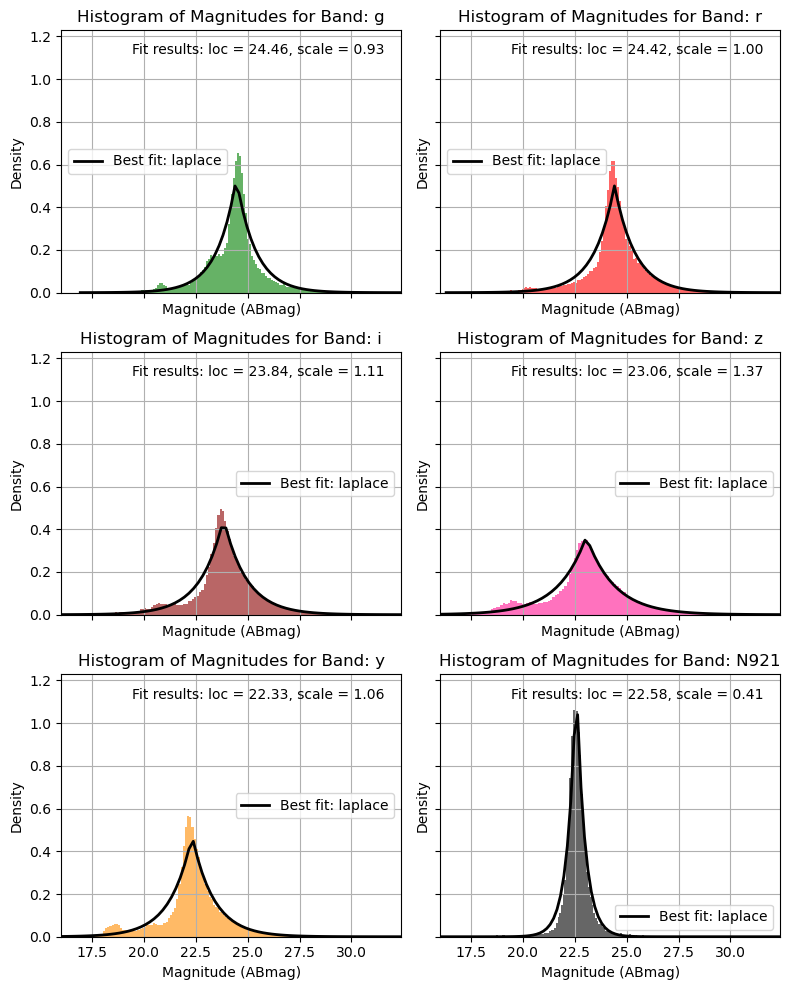

In [15]:
"""plot_magn('ap03Flux')
plot_magn('ap12Flux')
plot_magn('ap35Flux')
plot_magn('ap70Flux')"""
mag_distrib =  plot_magn('apFlux')

In [17]:
with open(f'saved/mag_distrib.pkl', 'wb') as f:
    pickle.dump(mag_distrib, f)


## Image zoomin and comparison with cutout 

In [19]:
visit = 1166
detector = 0
result = registry.queryDatasets(datasetType='goodSeeingDiff_differenceExp', 
                                collections=collection, 
                                where=f"visit = {visit} AND detector = {detector}")


In [20]:
from lsst.geom import Point2D, Box2I, Point2I, Extent2I
import lsst.afw.display as afwDisplay
import lsst.geom

In [21]:
def zoomed_pos_visit(image_type, visit, ra, dec, half_size): 
    
    result = registry.queryDatasets(datasetType='goodSeeingDiff_differenceExp', 
                                collections=collection, 
                                where=f"visit = {visit} AND detector = {detector}")


    for ref in result:      
        image = butler.get('goodSeeingDiff_differenceExp', dataId=ref.dataId)
        if image_type == 'coadd': 
            image = butler.get('goodSeeingDiff_templateExp', dataId=ref.dataId) 
        if image_type == 'calexp': 
            image = butler.get('calexp', dataId=ref.dataId)

        wcs = image.getWcs()

        # Convert target RA/Dec to pixel coordinates
        target_pixel =  wcs.skyToPixel(lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees))

        # Get the pixel coordinates of the center
        x_center = target_pixel.getX()
        y_center = target_pixel.getY()

        # Create bounding box for the subimage
        bbox = Box2I(Point2I(int(x_center - half_size), int(y_center - half_size)),
                     Extent2I(2 * half_size, 2 * half_size))
        
        # Ensure bbox is within image bounds
        if bbox.getMinX() < 0 or bbox.getMinY() < 0 or bbox.getMaxX() >= image.getWidth() or bbox.getMaxY() >= image.getHeight():
            print("Bounding box exceeds image dimensions. Adjusting...")
            bbox.clip(image.getBBox())

        subimage = image.Factory(image, bbox)
        afwDisplay.setDefaultBackend('matplotlib')
        fig = plt.figure(figsize=(10, 8))
        afw_display = afwDisplay.Display(1)
        afw_display.setMaskTransparency(100, 'DETECTED')
        afw_display.setMaskTransparency(100, 'STREAK')

        #afw_display.setMaskTransparency(100)
        afw_display.scale('asinh', 'zscale')
        afw_display.mtv(subimage)
        wcs = subimage.getWcs()
        afwDisplay.setDefaultBackend('matplotlib')
        fig = plt.figure(figsize=(10, 8))
        afw_display = afwDisplay.Display(1)
        afw_display.setMaskTransparency(100, 'DETECTED')
        afw_display.setMaskTransparency(100, 'STREAK')

        #afw_display.setMaskTransparency(100)
        afw_display.scale('asinh', 'zscale')
        afw_display.mtv(subimage)
        wcs = subimage.getWcs()
        

In [102]:
def zoomed_pos_visit(image_type, visit, diaObjectId, half_size, detector): 
    pd.set_option('display.float_format', lambda x: '%d' % x)

    with open("saved/full_dia_obj_table.pkl", "rb") as pickle_file:
        full_dia_obj_table = pickle.load(pickle_file)
    ra = full_dia_obj_table.loc[diaObjectId, 'ra']
    dec = full_dia_obj_table.loc[diaObjectId, 'dec']
    # Query datasets based on the specified visit and detector
    result = registry.queryDatasets(
        datasetType='goodSeeingDiff_differenceExp', 
        collections=collection, 
        where=f"visit = {visit} AND detector = {detector}"
    )

    for ref in result:      
        # Get the appropriate image based on the type
        base = butler.get('goodSeeingDiff_differenceExp', dataId=ref.dataId)

        wcs = base.getWcs()

        if image_type == 'diff': 
            image = butler.get('goodSeeingDiff_differenceExp', dataId=ref.dataId)
        if image_type == 'coadd': 
            image = butler.get('goodSeeingDiff_templateExp', dataId=ref.dataId) 
        elif image_type == 'calexp': 
            image = butler.get('calexp', dataId=ref.dataId)

        wcs = image.getWcs()

        # Convert target RA/Dec to pixel coordinates
        target_pixel = wcs.skyToPixel(lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees))

        # Get the pixel coordinates of the center
        x_center = target_pixel.getX()
        y_center = target_pixel.getY()

        # Create bounding box for the subimage
        bbox = Box2I(
            Point2I(int(x_center - half_size), int(y_center - half_size)),
            Extent2I(2 * half_size, 2 * half_size)
        )
        
        # Ensure bbox is within image bounds
        if bbox.getMinX() < 0 or bbox.getMinY() < 0 or bbox.getMaxX() >= image.getWidth() or bbox.getMaxY() >= image.getHeight():
            print("Bounding box exceeds image dimensions. Adjusting...")
            bbox.clip(image.getBBox())

        subimage = image.Factory(image, bbox)

        # Set up display using matplotlib
        afwDisplay.setDefaultBackend('matplotlib')
        fig = plt.figure(figsize=(10, 8))
        afw_display = afwDisplay.Display(1)
        afw_display.setMaskTransparency(100)


        # Display the subimage
        afw_display.scale('asinh', 'zscale')
        afw_display.mtv(subimage)

        # Optional: get the WCS of the subimage if needed
        subimage_wcs = subimage.getWcs()


In [103]:
with open("saved/full_dia_source_table_UDEEP.pkl", "rb") as pickle_file:
    full_dia_source_table_UDEEP = pickle.load(pickle_file)

In [109]:
full_dia_source_table_UDEEP[full_dia_source_table_UDEEP.index==138506252845074]

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec,is_injection
diaSourceId,,,,,,,,,,,,,,,,,,,,,
138506252845074,322,97,y,3496134715025392366,0,0,56741,20,2024-10-11 13:03:34.747943,150,...,False,False,False,False,False,False,False,150,2,0


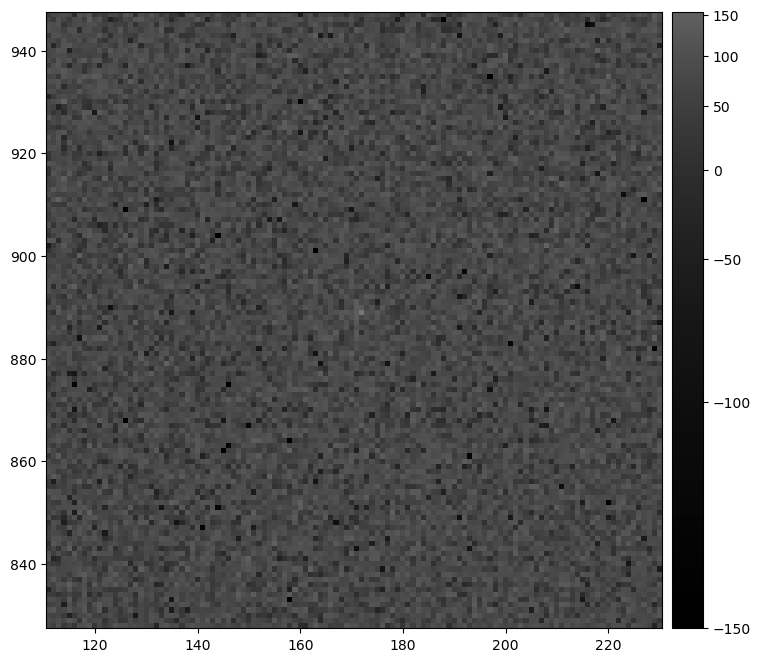

In [111]:
zoomed_pos_visit('diff', 322	, 3496134715025392366	, 60, 97)

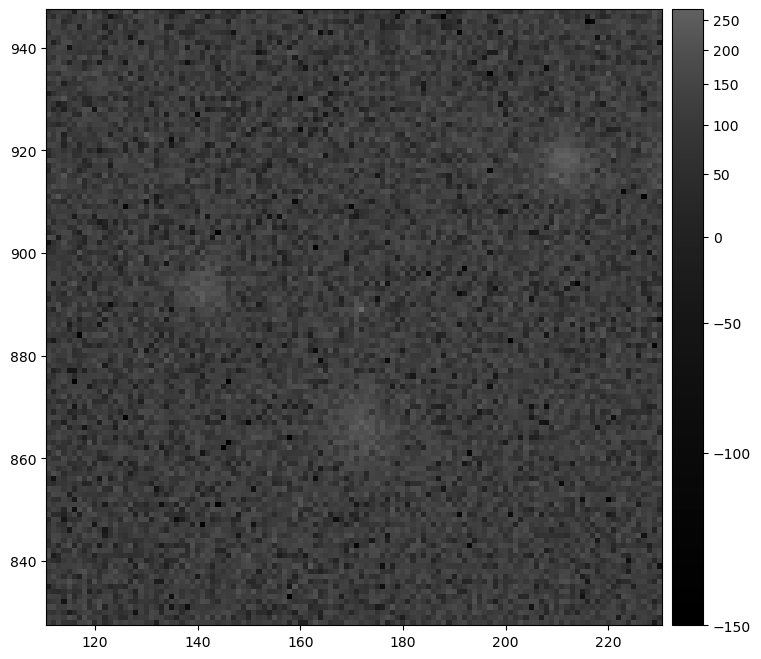

In [112]:
zoomed_pos_visit('calexp', 322	, 3496134715025392366	, 60, 97)

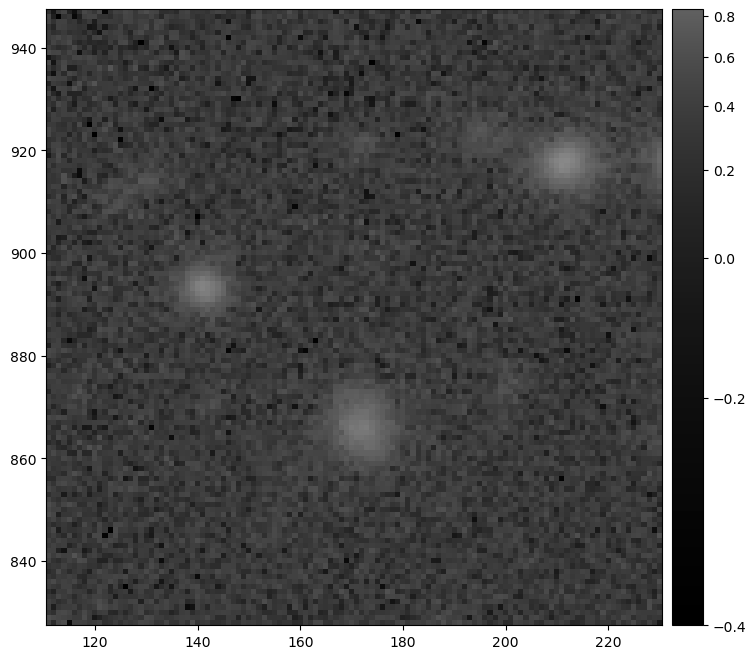

In [113]:
zoomed_pos_visit('coadd', 322	, 3496134715025392366	, 60, 97)

In [108]:
data_path ='/sps/lsst/groups/transients/HSC/fouchez/raphael'

with open(f"{data_path}/Detected_obj_sources_visit_106342_UDEEP.pkl", 'rb') as f:
    diff = pickle.load(f)
with open(f"{data_path}/Science_detected_obj_sources_visit_106342_UDEEP.pkl", 'rb') as f:
    calexp = pickle.load(f)
with open(f"{data_path}/Coadd_detected_obj_sources_visit_106342_UDEEP.pkl", 'rb') as f:
    coadd = pickle.load(f)
features = pd.read_pickle(f'{data_path}/Detected_obj_sources_visit_106342_UDEEP_df.pkl')


In [55]:
features

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,is_injection,rotation_angle
0,45673749525037062,106342,97,i,0,0,0,57835,25,2024-10-11 12:21:07.636047,...,False,False,False,False,False,False,False,False,0,None
1,45673749525037064,106342,97,i,0,0,0,57835,14,2024-10-11 12:21:07.636047,...,False,False,False,False,False,False,False,False,0,None
2,45673749525037065,106342,97,i,0,0,0,57835,16,2024-10-11 12:21:07.636047,...,False,False,False,False,False,False,False,False,0,None
3,45673749525037066,106342,97,i,0,0,0,57835,15,2024-10-11 12:21:07.636047,...,False,False,False,False,False,False,False,False,0,None
4,45673749525037072,106342,97,i,0,0,0,57835,16,2024-10-11 12:21:07.636047,...,False,False,False,False,False,False,False,False,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,45673736640135328,106342,91,i,0,0,0,57835,17,2024-10-11 11:12:31.765482,...,False,False,False,False,False,False,False,False,0,None
142,45673736640135329,106342,91,i,0,0,0,57835,30,2024-10-11 11:12:31.765482,...,False,False,False,False,False,False,False,False,0,None
143,45673736640135330,106342,91,i,0,0,0,57835,32,2024-10-11 11:12:31.765482,...,False,False,False,False,False,False,False,False,0,None
144,45673736640135331,106342,91,i,0,0,0,57835,21,2024-10-11 11:12:31.765482,...,False,False,False,False,False,False,False,False,0,None


In [57]:
idx_img = features[features['diaSourceId']==45673747377553573]
idx_img

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,is_injection,rotation_angle
63,45673747377553573,106342,96,i,0,0,0,57835,22,2024-10-11 11:07:42.509709,...,False,False,False,False,False,False,False,False,0,None


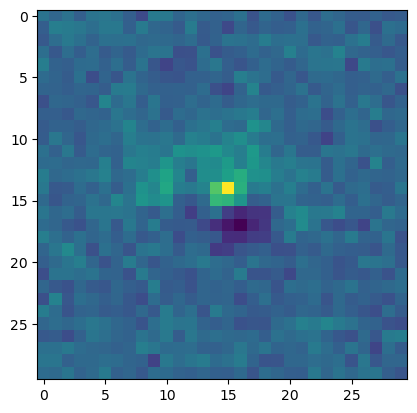

In [64]:
plt.imshow(diff[30])

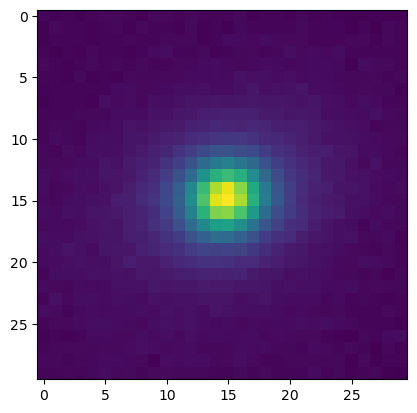

In [65]:
plt.imshow(calexp[30])

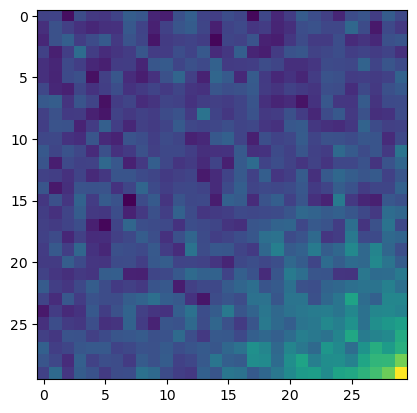

In [66]:
plt.imshow(coadd[30])

## Magnitude and PSF

In [22]:
mag_data = {band['band']: {'mag': [], 'mag_psf': []} for band in bands_label}

# Collect Flux values and convert them into magnitude 
for bandpass in bands_label:
    band = bandpass['band']
    for ref in extract_all_filter(bandpass):
        detecs = butler.get('sourceTable', dataId = ref)
        for detec in range (len(detecs)):
            psf = (np.array(detecs['psfFlux'])[detec])
            apflux = (np.array(detecs['ap12Flux'])[detec])
            mag = (apflux*u.nJy).to(u.ABmag)
            mag_psf = (psf*u.nJy).to(u.ABmag)
            # Check if magnitude is finite before appending
            if np.isfinite(mag.value) and np.isfinite(mag_psf.value):
                mag_data[band]['mag'].append(mag.value) 
                mag_data[band]['mag_psf'].append(mag_psf.value)
                

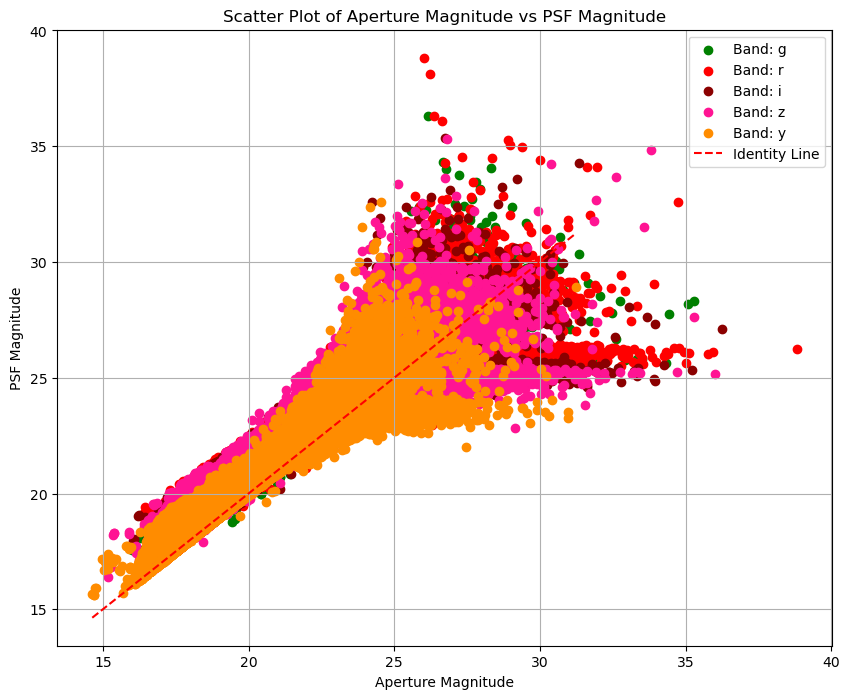

In [23]:
# Plotting the scatter plot for each band
band_colors = {
    'g': 'green',
    'r': 'red',
    'i': 'darkred',
    'y': 'darkorange',
    'z': 'deeppink' }

plt.figure(figsize=(10, 8))
for band in mag_data.keys():
    mag = mag_data[band]['mag']
    mag_psf = mag_data[band]['mag_psf']
    color = band_colors[band]

    plt.scatter(mag, mag_psf, label=f'Band: {band}', color = color)

plt.plot([min(mag), max(mag)], [min(mag), max(mag)], color='red', linestyle='--', label='Identity Line')
plt.xlabel('Aperture Magnitude')
plt.ylabel('PSF Magnitude')
plt.title('Scatter Plot of Aperture Magnitude vs PSF Magnitude')
plt.legend()
plt.grid(True)
plt.show()


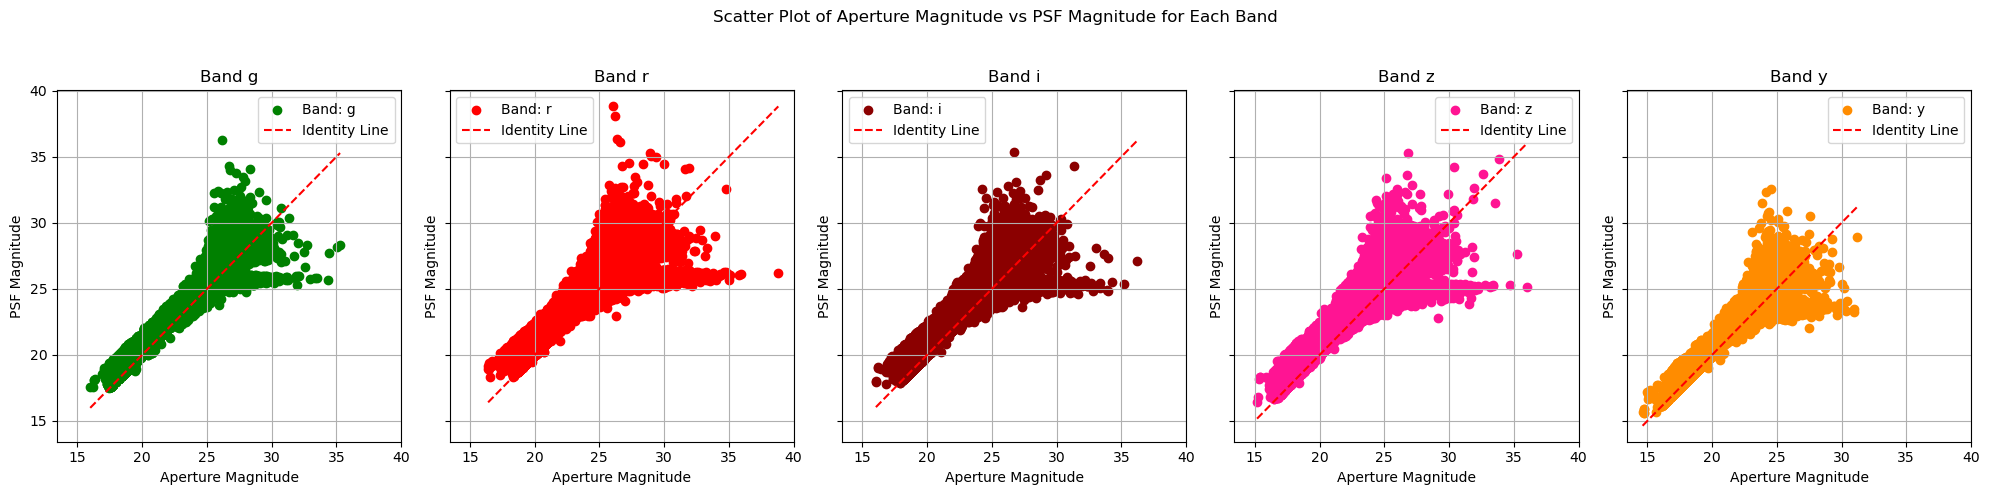

In [24]:
band_colors = {
    'g': 'green',
    'r': 'red',
    'i': 'darkred',
    'y': 'darkorange',
    'z': 'deeppink' }

# Plotting the scatter plots in a single figure with multiple subplots
fig, axs = plt.subplots(1, len(bands_label), figsize=(20, 5), sharex=True, sharey=True)

for ax, band in zip(axs, mag_data.keys()):
    mag = mag_data[band]['mag']
    mag_psf = mag_data[band]['mag_psf']
    color = band_colors[band]
    ax.scatter(mag, mag_psf, label=f'Band: {band}', color = color)
    ax.plot([min(mag), max(mag)], [min(mag), max(mag)], color='red', linestyle='--', label='Identity Line')
    ax.set_xlabel('Aperture Magnitude')
    ax.set_ylabel('PSF Magnitude')
    ax.set_title(f'Band {band}')
    ax.legend()
    ax.grid(True)

# Set the overall title for the figure
fig.suptitle('Scatter Plot of Aperture Magnitude vs PSF Magnitude for Each Band')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

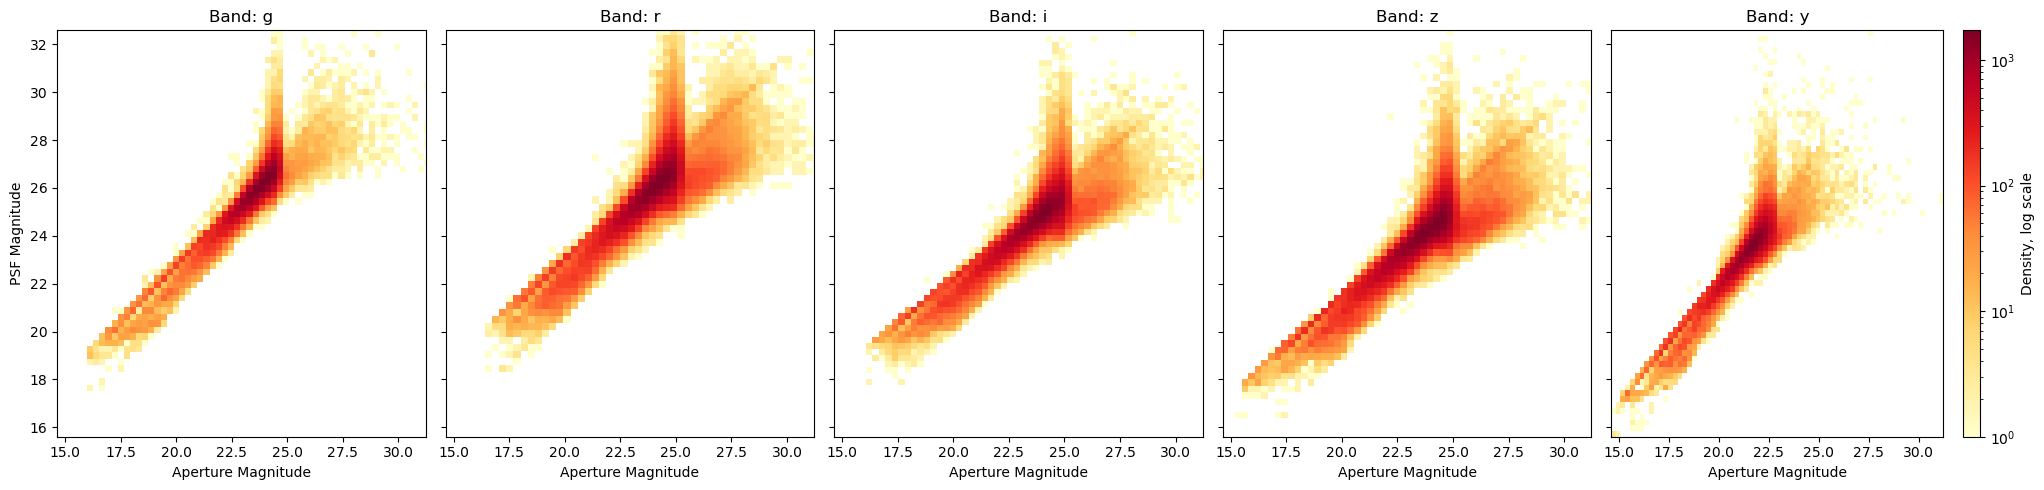

In [25]:
fig, axs = plt.subplots(1, len(bands_label), figsize=(20, 5), sharex=True, sharey=True)

for i, band in enumerate(mag_data.keys()):
    mag = mag_data[band]['mag']
    mag_psf = mag_data[band]['mag_psf']
    
    # Filter out NaN values
    mag = np.array(mag)
    mag_psf = np.array(mag_psf)
    valid_mask = np.isfinite(mag) & np.isfinite(mag_psf)
    mag = mag[valid_mask]
    mag_psf = mag_psf[valid_mask]
    
    # Create 2D histogram
    heatmap, xedges, yedges = np.histogram2d(mag, mag_psf, bins=70)
    
    # Plot the heatmap with a colormap
    im = axs[i].imshow((heatmap), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                       origin='lower', aspect='auto', cmap='YlOrRd', norm=LogNorm(vmin=1, vmax=heatmap.max()))
    axs[i].set_title(f'Band: {band}')
    axs[i].set_xlabel('Aperture Magnitude')
    if i == 0:
        axs[i].set_ylabel('PSF Magnitude')

# Adjust layout to accommodate colorbar
plt.tight_layout()

# Add a horizontal colorbar below the subplots
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Density, log scale')

plt.show()

In [26]:
print('hello')

hello


# Analysis on the sensor 

## CCD illumination 

In [27]:
dataIds = []
for i,ref in enumerate(datasetRefs):
    dataIds.append(ref.dataId.full)
print(len(dataIds))
print(dataIds[0])

240
{instrument: 'HSC', detector: 41, visit: 346, band: 'y', physical_filter: 'HSC-Y', visit_system: 0}


In [28]:
def extract_all_ccd(detector_num):
    dataIds = []
    result = registry.queryDatasets(datasetType='sourceTable', 
                                    collections=collection,
                                   where=f'detector = {detector_num}')

    for ref in result:
        dataIds.append(ref.dataId.full)
        
    return dataIds

In [29]:
ccds = []
for ref in datasetRefs:
    ccds.append(ref.dataId.full['detector'])
ccds = np.unique(ccds)

print(ccds)

[41 42 47 49 50 58]


In [30]:
print(extract_all_ccd(ccds[0]))


[{instrument: 'HSC', detector: 41, visit: 346, band: 'y', physical_filter: 'HSC-Y', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 29350, band: 'g', physical_filter: 'HSC-G', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 17926, band: 'z', physical_filter: 'HSC-Z', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 1242, band: 'i', physical_filter: 'HSC-I', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 19694, band: 'i', physical_filter: 'HSC-I', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 11740, band: 'y', physical_filter: 'HSC-Y', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 11710, band: 'g', physical_filter: 'HSC-G', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 17948, band: 'z', physical_filter: 'HSC-Z', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 1204, band: 'r', physical_filter: 'HSC-R', visit_system: 0}, {instrument: 'HSC', detector: 41, visit: 19680, band: 'i', physical_filter: 

In [31]:
# Collect x and y values for each ccd on different visits
x_y_data = {ccd: {'x': [], 'y': []} for ccd in ccds}

for ccd in ccds:
    for ref in extract_all_ccd(ccd):
        detecs = butler.get('sourceTable', dataId = ref)
        for detec in range (len(detecs)):
            x = (np.array(detecs['x'])[detec])
            y = (np.array(detecs['y'])[detec])
            x_y_data[ccd]['x'].append(x)
            x_y_data[ccd]['y'].append(y)


        
"""ra = (np.array(detecs['ra'])[detec])
            dec = (np.array(detecs['dec'])[detec])
            ra_dec_data[band]['ra'].append(ra)
            ra_dec_data[band]['dec'].append(dec)"""

"ra = (np.array(detecs['ra'])[detec])\n            dec = (np.array(detecs['dec'])[detec])\n            ra_dec_data[band]['ra'].append(ra)\n            ra_dec_data[band]['dec'].append(dec)"

41
42
47
49
50
58


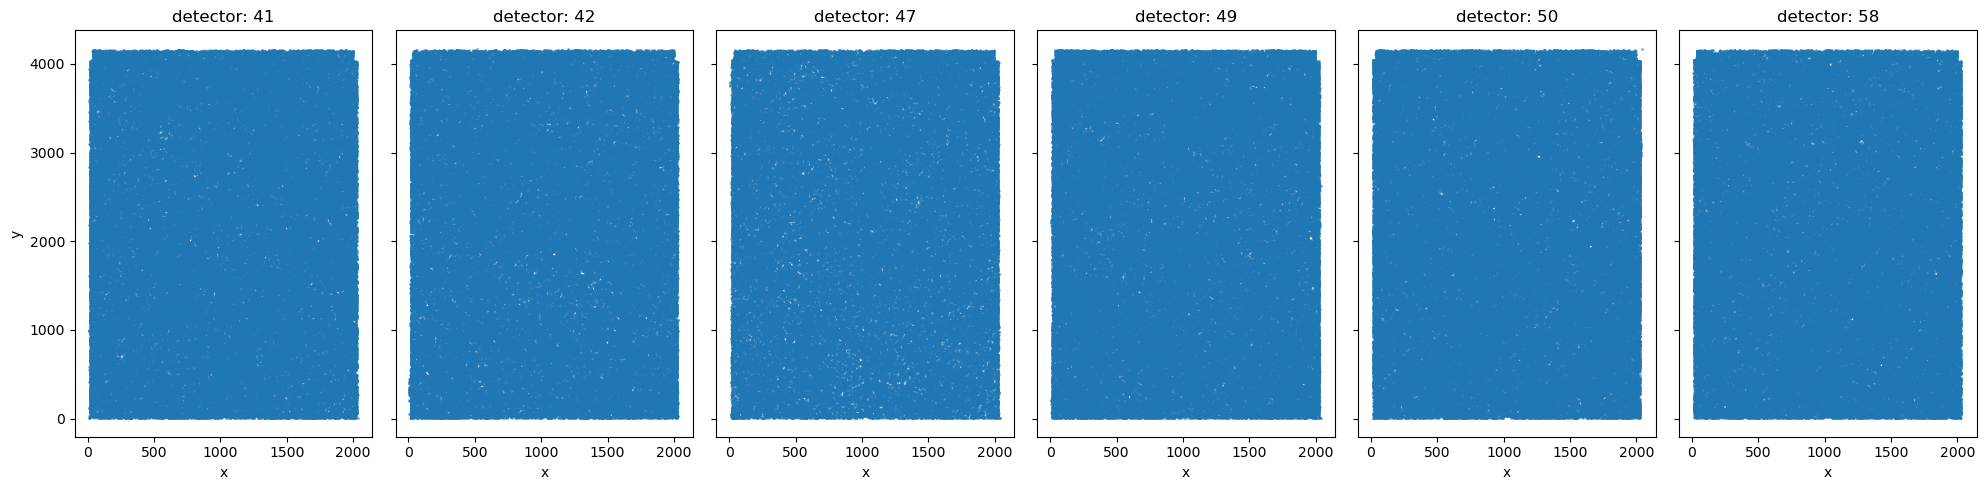

In [32]:
fig, axs = plt.subplots(1, len(ccds), figsize=(20, 5), sharex=True, sharey=True)

for i, ccd in enumerate(ccds):
    axs[i].scatter(x_y_data[ccd]['x'], x_y_data[ccd]['y'], s=1, alpha=0.5)
    axs[i].set_title(f'detector: {ccd}')
    axs[i].set_xlabel('x')
    if i == 0:
        axs[i].set_ylabel('y')
    print(ccd)

plt.tight_layout()
plt.show()

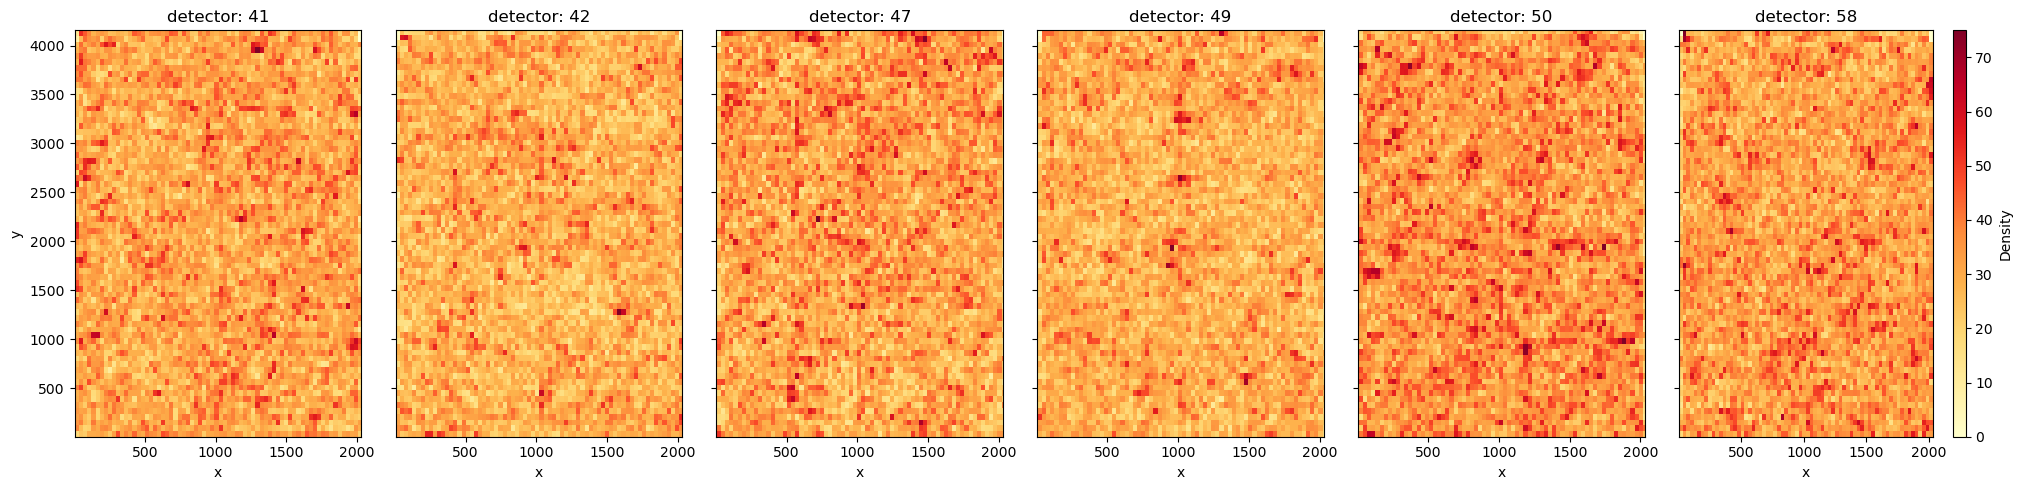

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot the distribution of RA and Dec positions as heat maps for each bandpass
fig, axs = plt.subplots(1, len(ccds), figsize=(20, 5), sharex=True, sharey=True)

for i, ccd in enumerate(ccds):
    x = x_y_data[ccd]['x']
    y = x_y_data[ccd]['y']
    
    # Create 2D histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=70)
    
    # Plot the heatmap with Greys colormap
    im = axs[i].imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                       origin='lower', aspect='auto', cmap='YlOrRd')
    axs[i].set_title(f'detector: {ccd}')
    axs[i].set_xlabel('x')
    if i == 0:
        axs[i].set_ylabel('y')

# Adjust layout to accommodate colorbar
plt.tight_layout()

# Add a horizontal colorbar below the subplots
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Density')

plt.show()

In [ ]:
fig, axes = plt.subplots(len(ccds), 1, figsize=(20, 5 * len(ccds)), sharex=True, sharey=True)
axes = np.atleast_1d(axes).flatten()

for i, ccd in enumerate(ccds):
    axes[i].hist(x_y_data[ccd]['x'], histtype='step', bins=np.arange(-100, 2100, 5), label='X')
    axes[i].hist(x_y_data[ccd]['y'], histtype='step', bins=np.arange(-100, 4200, 10), label='Y')

    axes[i].set_title(f'detector : {ccd}')
    axes[i].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

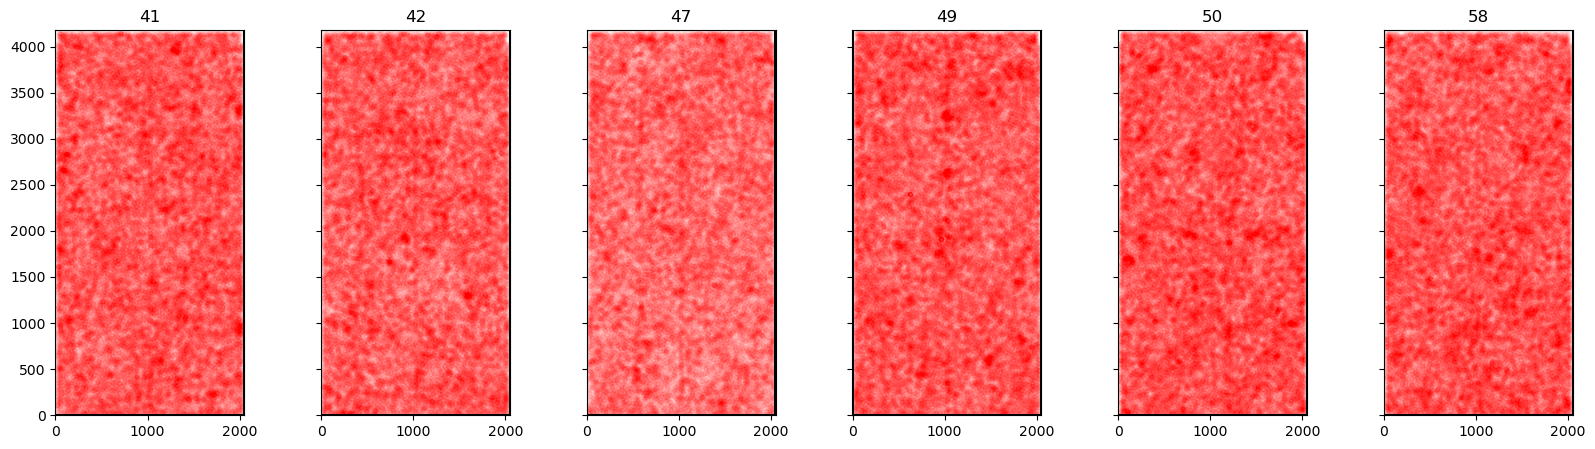

In [35]:
fig, axes = plt.subplots(1, len(ccds), figsize=(20, 5), sharex=True, sharey=True)

for i, ccd in enumerate(ccds):     
    axes[i].plot(x_y_data[ccd]['x'], x_y_data[ccd]['y'], 'r.', alpha=0.01)
    axes[i].set_xlim(-2, 2050)
    axes[i].set_ylim(-2, 4178)
    axes[i].set_aspect('equal')
    axes[i].hlines(xmin=0, xmax=2048, y=[0, 4176], color='black')
    axes[i].vlines(ymin=0, ymax=4176, x=[0, 2048], color='black')
    axes[i].set_title(ccd)

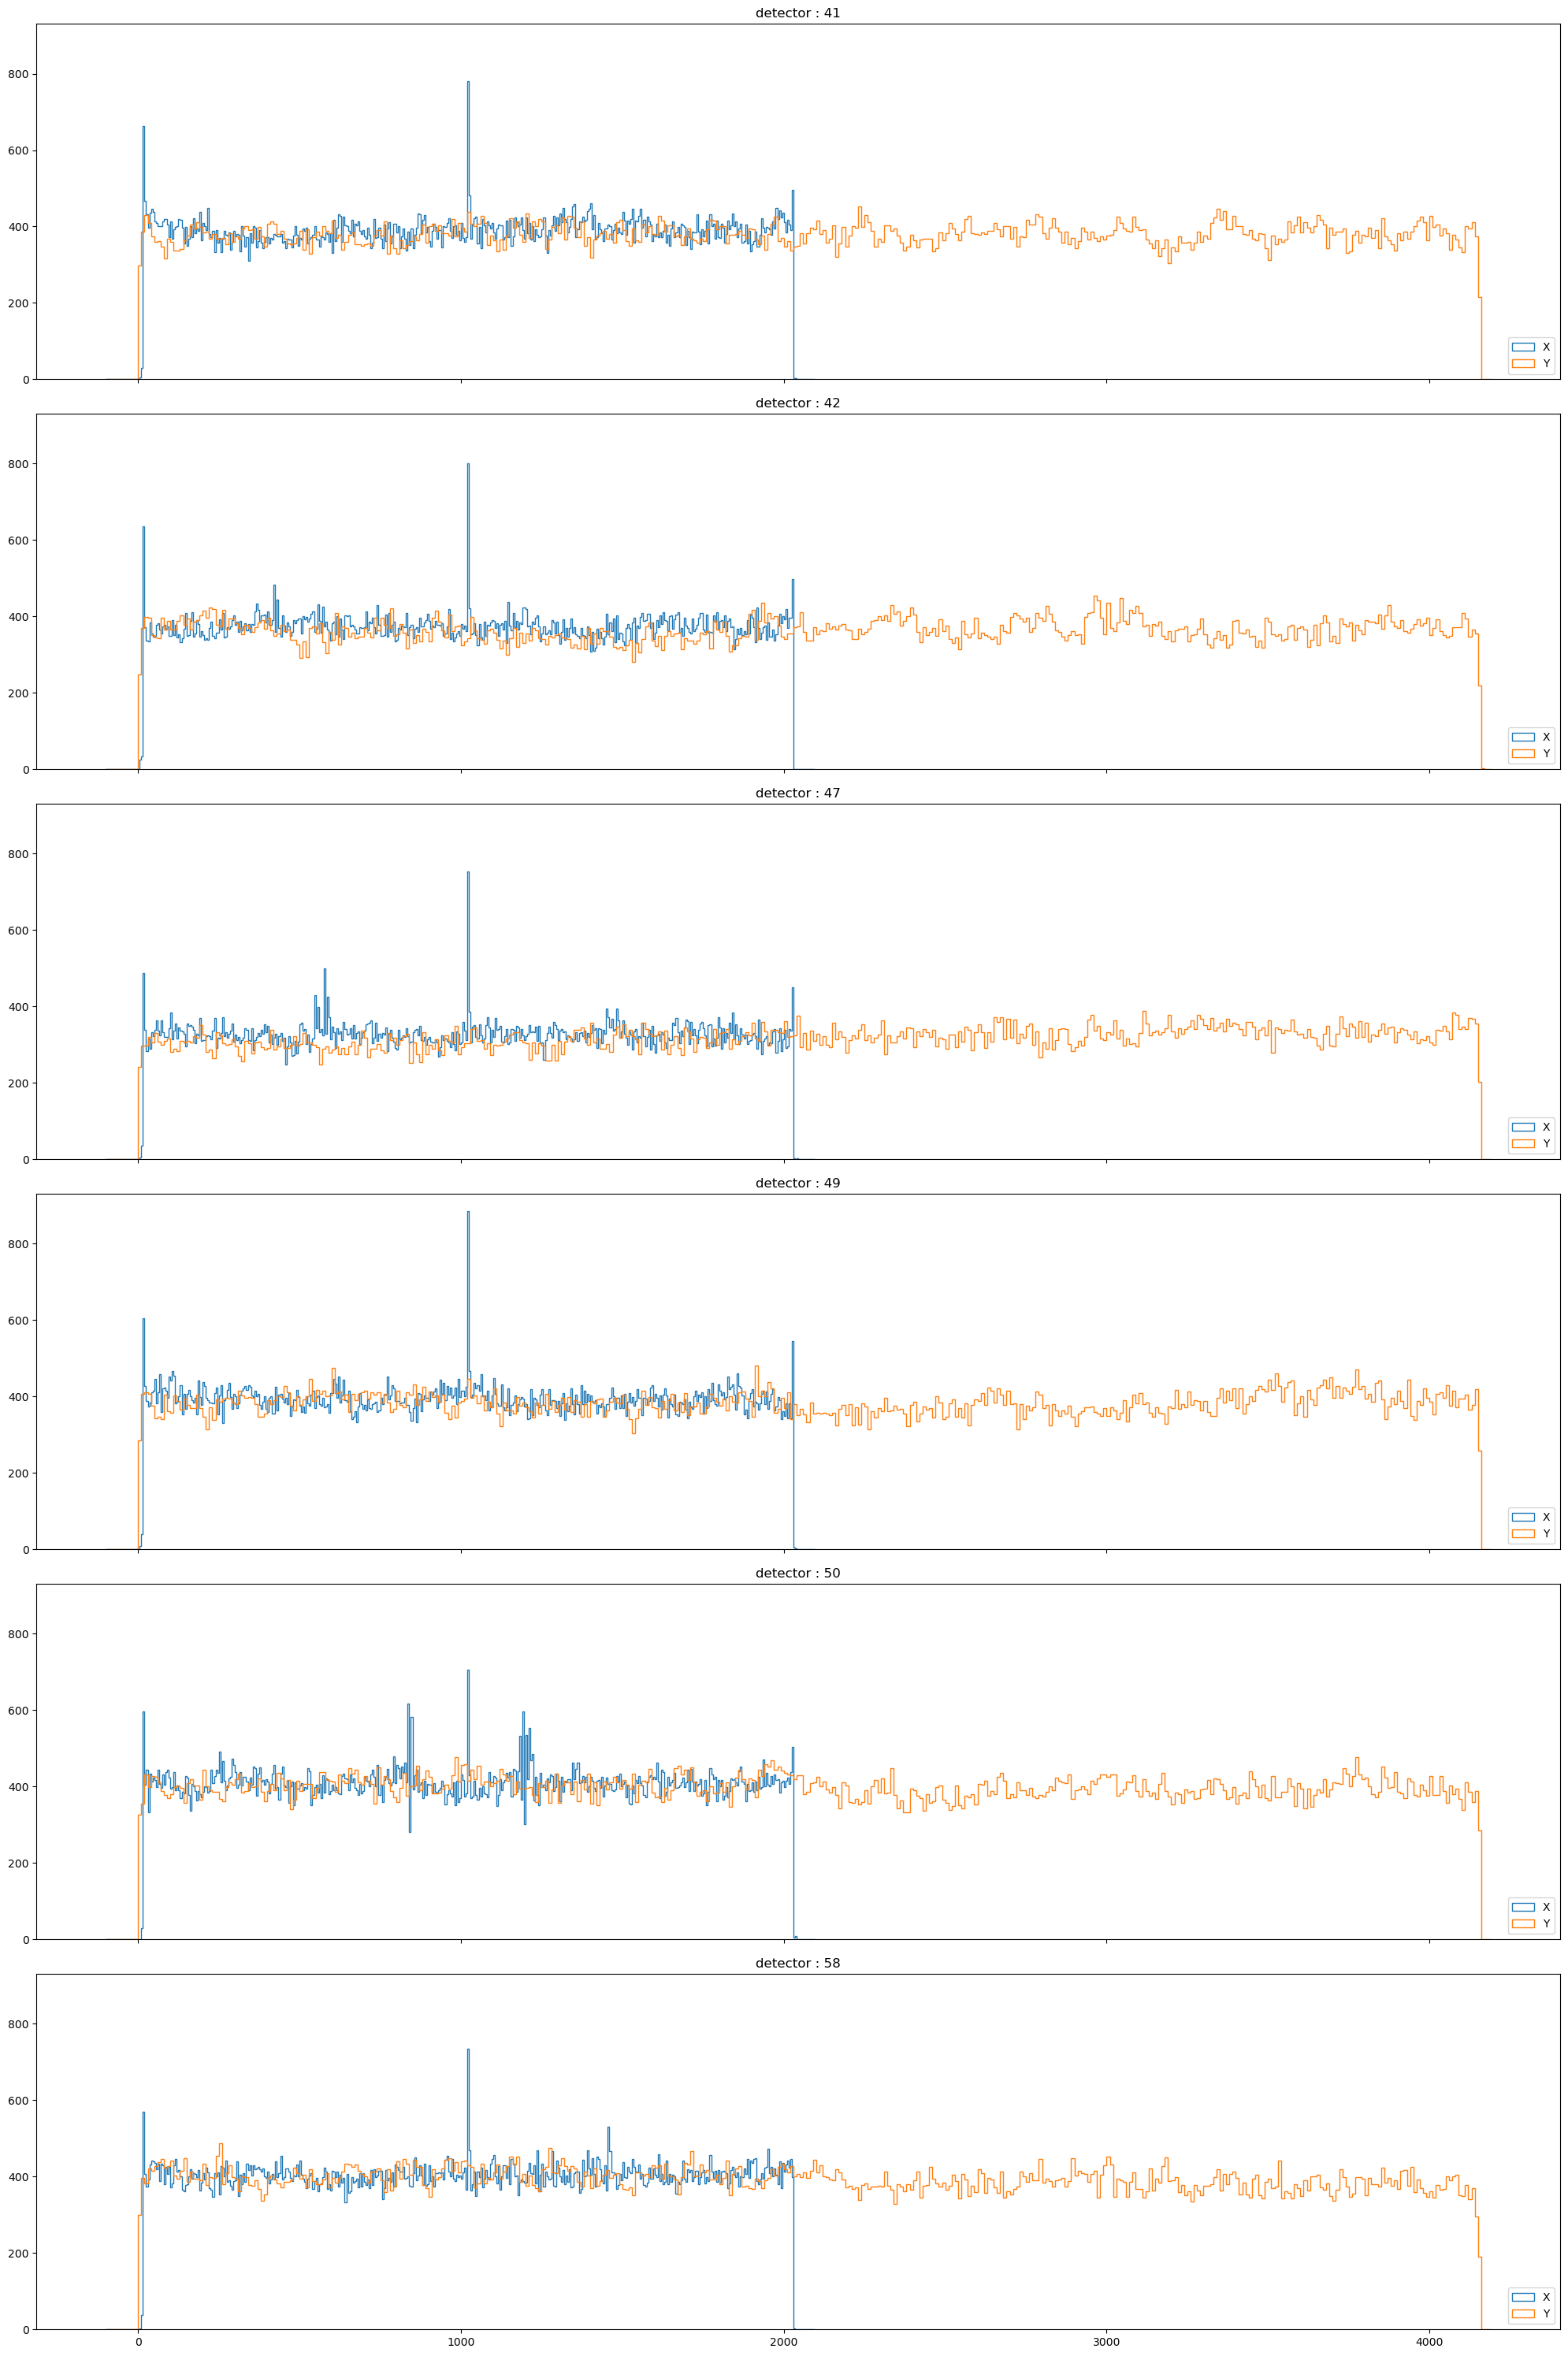

In [37]:
fig, axes = plt.subplots(len(ccds), 1, figsize=(20, 5 * len(ccds)), sharex=True, sharey=True)
axes = np.atleast_1d(axes).flatten()

for i, ccd in enumerate(ccds):
    axes[i].hist(x_y_data[ccd]['x'], histtype='step', bins=np.arange(-100, 2100, 5), label='X')
    axes[i].hist(x_y_data[ccd]['y'], histtype='step', bins=np.arange(-100, 4200, 10), label='Y')

    axes[i].set_title(f'detector : {ccd}')
    axes[i].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()